# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ). 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

In [4]:
# Import necessary libraries
import os
import pandas as pd
import boto3
import io
import re
from sklearn.model_selection import train_test_split
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
# Load custom dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [6]:
# Initialize SageMaker session and region
sess = sagemaker.Session()
region = boto3.Session().region_name

In [ ]:
# List all buckets
existing_buckets = s3.list_buckets()
print([bucket['Name'] for bucket in existing_buckets['Buckets']])

In [10]:
# S3 bucket for saving code and model artifacts
# Initialize SageMaker session and specify bucket and prefix
sess = sagemaker.Session()
bucket_name = 'c135321a3429022l8214472t1w590183749102-labbucket-sgu9pygz06aq'
prefix = 'linear'

In [11]:
# Define IAM role
role = get_execution_role()


In [12]:
s3 = boto3.client('s3')
s3.create_bucket(Bucket=bucket_name)

{'ResponseMetadata': {'RequestId': 'EBC2BFJX6DDWCQTG',
  'HostId': '2+rFAFrom8rTOmTdZ51QZI6CA47o/hGuG/etRQnAqTMqfyj3o9pRgndkxCVZBi+ktVrZWqbcPtk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '2+rFAFrom8rTOmTdZ51QZI6CA47o/hGuG/etRQnAqTMqfyj3o9pRgndkxCVZBi+ktVrZWqbcPtk=',
   'x-amz-request-id': 'EBC2BFJX6DDWCQTG',
   'date': 'Sun, 03 Nov 2024 12:04:59 GMT',
   'location': '/c135321a3429022l8214472t1w590183749102-labbucket-sgu9pygz06aq',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Location': '/c135321a3429022l8214472t1w590183749102-labbucket-sgu9pygz06aq'}

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [13]:
# Load your dataset
df1 = pd.read_csv('combined_csv_v1.csv')
df1 = df1.replace({True: 1, False: 0})

In [14]:
# Split data into train, validation, and test sets
train_df, test_val_df = train_test_split(df1, test_size=0.3, random_state=42, stratify=df1['target'])
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42, stratify=test_val_df['target'])


# Separate features and labels
train_features = train_df.drop(columns=['target']).values.astype('float32')
train_labels = train_df['target'].values.astype('float32')
val_features = val_df.drop(columns=['target']).values.astype('float32')
val_labels = val_df['target'].values.astype('float32')
test_features = test_df.drop(columns=['target']).values.astype('float32')
test_labels = test_df['target'].values.astype('float32')

In [15]:
import sagemaker.amazon.common as smac

# Convert to RecordIO format and write to in-memory buffers
train_set_buf = io.BytesIO()
validation_set_buf = io.BytesIO()
test_set_buf = io.BytesIO()


smac.write_numpy_to_dense_tensor(train_set_buf, train_features, train_labels)
smac.write_numpy_to_dense_tensor(validation_set_buf, val_features, val_labels)
smac.write_numpy_to_dense_tensor(test_set_buf, test_features, test_labels)

train_set_buf.seek(0)
validation_set_buf.seek(0)
test_set_buf.seek(0)


0

In [16]:
# Upload the RecordIO formatted datasets to S3
s3_resource = boto3.resource('s3')

train_s3_path = f"{prefix}/train/train1.recordio"
val_s3_path = f"{prefix}/validate/validate1.recordio"
test_s3_path = f"{prefix}/test/test1.recordio"

# Upload datasets to S3
s3_resource.Bucket(bucket_name).Object(train_s3_path).upload_fileobj(train_set_buf)
s3_resource.Bucket(bucket_name).Object(val_s3_path).upload_fileobj(validation_set_buf)
s3_resource.Bucket(bucket_name).Object(test_s3_path).upload_fileobj(test_set_buf)

train_s3_uri = f"s3://{bucket_name}/{train_s3_path}"
val_s3_uri = f"s3://{bucket_name}/{val_s3_path}"
test_s3_uri = f"s3://{bucket_name}/{test_s3_path}"

# Define data channels for training and validation
data_channels = {
    'train': train_s3_uri,'validation': val_s3_uri}



In [17]:
# Define data channels for training and validation

# Set up the Linear Learner estimator
from sagemaker import image_uris

container = image_uris.retrieve(region=sess.boto_region_name, framework="linear-learner")
linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=f"s3://{bucket_name}/{prefix}/output",
    sagemaker_session=sess,
)
linear.set_hyperparameters(feature_dim=train_features.shape[1], predictor_type="binary_classifier", mini_batch_size=200, epochs =5)

# Fit the model
linear.fit(data_channels)

INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-03-12-06-40-451


2024-11-03 12:06:41 Starting - Starting the training job...
2024-11-03 12:06:56 Starting - Preparing the instances for training...
2024-11-03 12:07:20 Downloading - Downloading input data...
2024-11-03 12:08:00 Downloading - Downloading the training image.........
2024-11-03 12:09:32 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2024 12:09:41 INFO 140606159963968] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

### Host

In [18]:
linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge"
)

INFO:sagemaker:Creating model with name: linear-learner-2024-11-03-12-20-37-764
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-11-03-12-20-37-764
INFO:sagemaker:Creating endpoint with name linear-learner-2024-11-03-12-20-37-764


--------!

In [19]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set the serializer and deserializer
linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

# Select a single row for prediction (e.g., 30th row)
single_sample = train_features[30:31]

# Make a prediction for this single record
result = linear_predictor.predict(single_sample, initial_args={"ContentType": "text/csv"})
print(result)

{'predictions': [{'score': 0.13119086623191833, 'predicted_label': 0}]}


In [20]:
import numpy as np

# Batch prediction for a subset of the training data (e.g., first 100 rows)
batch_samples = train_features[:100]

# Run batch prediction
predictions = []
for array in np.array_split(batch_samples, 10):  # Splitting into smaller batches
    result = linear_predictor.predict(array, initial_args={"ContentType": "text/csv"})
    predictions.extend([r["predicted_label"] for r in result["predictions"]])



In [21]:
# Convert predictions to a numpy array for analysis
predictions = np.array(predictions)

# Print the predictions
print("Batch predictions:", predictions)

Batch predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### Batch Transformation

In [22]:
batch_X = test_df.drop(columns=['target'])

In [23]:
# Save the test features as CSV
batch_X_file = 'batch-in.csv'
batch_X.to_csv(batch_X_file, index=False, header=False)

In [24]:
# Define S3 paths for input and output
batch_input = f"s3://{bucket_name}/{prefix}/batch-in/{batch_X_file}"
batch_output = f"s3://{bucket_name}/{prefix}/batch-out/"

In [25]:
# Upload test data to S3
s3_resource = boto3.resource('s3')
s3_resource.Bucket(bucket_name).Object(f"{prefix}/batch-in/{batch_X_file}").upload_file(batch_X_file)


In [26]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name=linear_predictor.endpoint_name,  # The deployed model's endpoint name
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",  # Use MultiRecord for batch processing
    assemble_with="Line",
    output_path=batch_output
)

In [27]:
transformer.transform(
    data=batch_input,
    data_type="S3Prefix",
    content_type="text/csv",
    split_type="Line"
)


INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-03-12-25-13-479


............................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 12:32:32 INFO 139790925600576] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 12:32:32 INFO 139790925600576] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy

In [28]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=f"{prefix}/batch-out/{batch_X_file}.out")
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predicted_label'])

In [29]:
def extract_score(row):
    # Look for the pattern 'score:<value>' and extract the value
    match = re.search(r"score:([0-9.]+)", row)
    if match:
        return float(match.group(1))
    else:
        return None

# Apply the function to extract scores
target_predicted['score'] = target_predicted['predicted_label'].apply(extract_score)

# Check if the score extraction worked
print(target_predicted['score'].head())

# Define the binary conversion function
def binary_convert(x):
    threshold = 0.3
    return 1 if x > threshold else 0

# Convert scores to binary predictions
target_predicted_binary = target_predicted['score'].apply(binary_convert)



{"predicted_label":0    0.117096
{"predicted_label":0    0.206897
{"predicted_label":0    0.304052
{"predicted_label":0    0.210426
{"predicted_label":0    0.262762
Name: score, dtype: float64


In [30]:
print("Binary predictions:\n", target_predicted_binary.head())

Binary predictions:
 {"predicted_label":0    0
{"predicted_label":0    0
{"predicted_label":0    1
{"predicted_label":0    0
{"predicted_label":0    0
Name: score, dtype: int64


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(test_labels, target_predicted_binary)

# Create a DataFrame for better readability
df_confusion = pd.DataFrame(matrix, index=['No Delay', 'Delay'], columns=['No Delay', 'Delay'])

df_confusion

,No Delay,Delay
No Delay,174005,19834
Delay,40441,11059


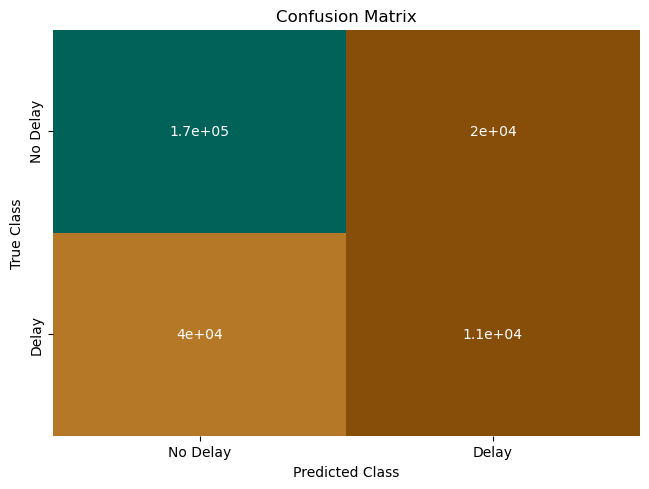

In [32]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

### Calculating performance metrics

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 174005
False Positive (FP): 19834
False Negative (FN): 40441
True Positive (TP) : 11059


In [34]:
# Sensitivity, also known as Recall or True Positive Rate (TPR)
sensitivity = TP / (TP + FN)
print(f"Sensitivity (Recall): There is a {sensitivity:.2%} chance of detecting a delay when it actually occurs.")



Sensitivity (Recall): There is a 21.47% chance of detecting a delay when it actually occurs.


In [35]:
# Specificity, also known as True Negative Rate (TNR)
specificity = TN / (TN + FP)
print(f"Specificity (TNR): There is a {specificity:.2%} chance of correctly identifying a non-delay.")

Specificity (TNR): There is a 89.77% chance of correctly identifying a non-delay.


In [36]:
# Precision calculation
precision = TP / (TP + FP)
print(f"Precision: There is a {precision:.2%} chance that a predicted delay is actually a delay.")


Precision: There is a 35.80% chance that a predicted delay is actually a delay.


In [37]:


# F1 Score calculation
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
print(f"F1 Score: The balance between precision and sensitivity is {f1_score:.2%}.")

F1 Score: The balance between precision and sensitivity is 26.84%.


In [38]:
# False Positive Rate (FPR)
fpr = FP / (FP + TN)
print(f"False Positive Rate (FPR): There is a {fpr:.2%} chance of predicting a delay when there isn't one.")

False Positive Rate (FPR): There is a 10.23% chance of predicting a delay when there isn't one.


In [39]:
# False Negative Rate (FNR)
fnr = FN / (FN + TP)
print(f"False Negative Rate (FNR): There is a {fnr:.2%} chance of failing to predict a delay when there is one.")

False Negative Rate (FNR): There is a 78.53% chance of failing to predict a delay when there is one.


In [40]:
npv = TN / (TN + FN) * 100

In [41]:

# False Discovery Rate (FDR)
fdr = FP / (FP + TP)
print(f"False Discovery Rate (FDR): There is a {fdr:.2%} chance of predicting a delay incorrectly.")


False Discovery Rate (FDR): There is a 64.20% chance of predicting a delay incorrectly.


In [42]:

# Overall Accuracy
accuracy = accuracy_score(test_labels, target_predicted_binary)
print(f"Overall Accuracy: The model correctly predicts delays and non-delays with an accuracy of {accuracy:.2%}.")

Overall Accuracy: The model correctly predicts delays and non-delays with an accuracy of 75.43%.


In [43]:

print(f"Sensitivity or Recall: {sensitivity:.2f}%")
print(f"Specificity or TNR: {specificity:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Negative Predictive Value: {npv:.2f}%")
print(f"F-1 score: {f1_score:.2f}%")
print(f"False Positive Rate: {fpr:.2f}%")
print(f"False Negative Rate: {fnr:.2f}%")
print(f"False Discovery Rate: {fdr:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

Sensitivity or Recall: 0.21%
Specificity or TNR: 0.90%
Precision: 0.36%
Negative Predictive Value: 81.14%
F-1 score: 0.27%
False Positive Rate: 0.10%
False Negative Rate: 0.79%
False Discovery Rate: 0.64%
Accuracy: 0.75%


## Dataset 2 - Linear Lerner

In [44]:
df2 = pd.read_csv('combined_csv_v2.csv')
df2 = df2.replace({True: 1, False: 0})

In [45]:
# Split data into train, validation, and test sets
train_df2, test_val_df2 = train_test_split(df2, test_size=0.3, random_state=42, stratify=df2['target'])
val_df2, test_df2 = train_test_split(test_val_df2, test_size=0.5, random_state=42, stratify=test_val_df2['target'])

# Separate features and labels
train_features2 = train_df2.drop(columns=['target']).values.astype('float32')
train_labels2 = train_df2['target'].values.astype('float32')
val_features2 = val_df2.drop(columns=['target']).values.astype('float32')
val_labels2 = val_df2['target'].values.astype('float32')
test_features2 = test_df2.drop(columns=['target']).values.astype('float32')
test_labels2 = test_df2['target'].values.astype('float32')

In [46]:
# Convert to RecordIO format and write to in-memory buffers
train_set_buf2 = io.BytesIO()
validation_set_buf2 = io.BytesIO()
test_set_buf2 = io.BytesIO()

smac.write_numpy_to_dense_tensor(train_set_buf2, train_features2, train_labels2)
smac.write_numpy_to_dense_tensor(validation_set_buf2, val_features2, val_labels2)
smac.write_numpy_to_dense_tensor(test_set_buf2, test_features2, test_labels2)

train_set_buf2.seek(0)
validation_set_buf2.seek(0)
test_set_buf2.seek(0)

0

In [47]:
# Convert to RecordIO format and write to in-memory buffers
train_set_buf2 = io.BytesIO()
validation_set_buf2 = io.BytesIO()
test_set_buf2 = io.BytesIO()

smac.write_numpy_to_dense_tensor(train_set_buf2, train_features2, train_labels2)
smac.write_numpy_to_dense_tensor(validation_set_buf2, val_features2, val_labels2)
smac.write_numpy_to_dense_tensor(test_set_buf2, test_features2, test_labels2)

train_set_buf2.seek(0)
validation_set_buf2.seek(0)
test_set_buf2.seek(0)

0

In [48]:
# Define new S3 paths for the second dataset
train_s3_path2 = f"{prefix}/train/train2.recordio"
val_s3_path2 = f"{prefix}/validate/validate2.recordio"
test_s3_path2 = f"{prefix}/test/test2.recordio"

# Upload datasets to S3
s3_resource.Bucket(bucket_name).Object(train_s3_path2).upload_fileobj(train_set_buf2)
s3_resource.Bucket(bucket_name).Object(val_s3_path2).upload_fileobj(validation_set_buf2)
s3_resource.Bucket(bucket_name).Object(test_s3_path2).upload_fileobj(test_set_buf2)

train_s3_uri2 = f"s3://{bucket_name}/{train_s3_path2}"
val_s3_uri2 = f"s3://{bucket_name}/{val_s3_path2}"
test_s3_uri2 = f"s3://{bucket_name}/{test_s3_path2}"

# Define data channels
data_channels2 = {'train': train_s3_uri2, 'validation': val_s3_uri2}

In [ ]:
# Initialize the estimator
linear2 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=f"s3://{bucket_name}/{prefix}/output2",
    sagemaker_session=sess,
)
linear2.set_hyperparameters(feature_dim=train_features2.shape[1], predictor_type="binary_classifier", mini_batch_size=200, epochs=5)

# Fit the model
linear2.fit(data_channels2)

INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-03-12-35-37-954


2024-11-03 12:35:39 Starting - Starting the training job...
2024-11-03 12:35:53 Starting - Preparing the instances for training...
2024-11-03 12:36:26 Downloading - Downloading input data......
2024-11-03 12:37:22 Downloading - Downloading the training image......
2024-11-03 12:38:43 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/03/2024 12:38:53 INFO 139752866015040] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

In [ ]:
linear_predictor2 = linear2.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge"
)

In [ ]:
linear_predictor2.serializer = CSVSerializer()
linear_predictor2.deserializer = JSONDeserializer()

In [ ]:
# Prepare test data for batch transform
batch_X2 = test_df2.drop(columns=['target'])
batch_X_file2 = 'batch-in2.csv'
batch_X2.to_csv(batch_X_file2, index=False, header=False)

In [ ]:
# Define S3 paths for input and output for df2
batch_input2 = f"s3://{bucket_name}/{prefix}/batch-in/{batch_X_file2}"
batch_output2 = f"s3://{bucket_name}/{prefix}/batch-out2/"

# Upload the test file to S3 for batch transform
s3_resource.Bucket(bucket_name).Object(f"{prefix}/batch-in/{batch_X_file2}").upload_file(batch_X_file2)

In [ ]:
transformer2 = Transformer(
    model_name=linear_predictor2.endpoint_name,  # The deployed model's endpoint name for df2
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",  # Use MultiRecord for batch processing
    assemble_with="Line",
    output_path=batch_output2
)

# Run batch transform
transformer2.transform(
    data=batch_input2,
    data_type="S3Prefix",
    content_type="text/csv",
    split_type="Line"
)

In [ ]:
# Retrieve predictions from S3
obj2 = s3.get_object(Bucket=bucket_name, Key=f"{prefix}/batch-out2/{batch_X_file2}.out")
target_predicted2 = pd.read_csv(io.BytesIO(obj2['Body'].read()), names=['predicted_label'])

In [ ]:
# Extract scores from predictions
target_predicted2['score'] = target_predicted2['predicted_label'].apply(extract_score)

In [ ]:
# Define the binary conversion function and apply it to scores
target_predicted_binary2 = target_predicted2['score'].apply(binary_convert)
print("Binary predictions for df2:\n", target_predicted_binary2.head())

In [ ]:


# Calculate confusion matrix
matrix2 = confusion_matrix(test_labels2, target_predicted_binary2)

# Create a DataFrame for better readability
df_confusion2 = pd.DataFrame(matrix2, index=['No Delay', 'Delay'], columns=['No Delay', 'Delay'])

# Plot the confusion matrix
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion2, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix for df2")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Extract TN, FP, FN, TP
TN2, FP2, FN2, TP2 = confusion_matrix(test_labels2, target_predicted_binary2).ravel()

print(f"True Negative (TN) : {TN2}")
print(f"False Positive (FP): {FP2}")
print(f"False Negative (FN): {FN2}")
print(f"True Positive (TP) : {TP2}")

In [ ]:
# Sensitivity (Recall / True Positive Rate)
sensitivity2 = TP2 / (TP2 + FN2)
print(f"Sensitivity (Recall): There is a {sensitivity2:.2%} chance of detecting a delay when it actually occurs.")

In [ ]:
# Specificity (True Negative Rate)
specificity2 = TN2 / (TN2 + FP2)
print(f"Specificity (TNR): There is a {specificity2:.2%} chance of correctly identifying a non-delay.")

In [ ]:
# Precision
precision2 = precision_score(test_labels2, target_predicted_binary2) * 100
print(f"Precision: Of all predicted delays, {precision2:.2f}% were actual delays.")

In [ ]:
# Negative Predictive Value (NPV)
npv2 = TN2 / (TN2 + FN2) * 100
print(f"Negative Predictive Value (NPV): Of all predicted non-delays, {npv2:.2f}% were actually non-delays.")

In [ ]:
# F1 Score
f1_score2 = f1_score(test_labels2, target_predicted_binary2) * 100
print(f"F1 Score: The harmonic mean of Precision and Recall is {f1_score2:.2f}%.")

In [ ]:
# False Positive Rate (FPR)
fpr2 = FP2 / (FP2 + TN2) * 100
print(f"False Positive Rate (FPR): There is a {fpr2:.2f}% chance of predicting a delay when there isn’t one.")

In [ ]:
# False Negative Rate (FNR)
fnr2 = FN2 / (FN2 + TP2) * 100
print(f"False Negative Rate (FNR): There is a {fnr2:.2f}% chance of predicting no delay when there actually is one.")

In [ ]:
# False Discovery Rate (FDR)
fdr2 = FP2 / (FP2 + TP2) * 100
print(f"False Discovery Rate (FDR): Of all predicted delays, {fdr2:.2f}% were actually non-delays.")

In [ ]:
# Accuracy
accuracy2 = accuracy_score(test_labels2, target_predicted_binary2) * 100
print(f"Accuracy: The overall correctness of the model is {accuracy2:.2f}%.")

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

## Dataset 1- XG BOOST

In [ ]:
# Define filenames for CSV uploads
train_file = 'flight_train.csv'
validate_file = 'flight_validate.csv'

In [ ]:
# Initialize s3_resource
s3_resource = boto3.resource('s3') 

In [ ]:
# Helper function to upload dataframes to S3 as CSV
def upload_s3_csv(dataframe, filename, folder):
    csv_buffer = io.StringIO()
    # Write to CSV with explicit comma delimiter and no header
    dataframe.to_csv(csv_buffer, header=False, index=False, sep=',')
    s3_resource.Bucket(bucket_name).Object(f"{prefix}/{folder}/{filename}").put(Body=csv_buffer.getvalue())
    return f"s3://{bucket_name}/{prefix}/{folder}/{filename}"



In [ ]:
# Upload the datasets as CSV files without headers and enforced comma delimiter
train_s3_uri = upload_s3_csv(train_df, train_file, 'train')
val_s3_uri = upload_s3_csv(val_df, validate_file, 'validate')


In [ ]:
# Set up TrainingInput for each channel, specifying content type as text/csv
train_channel = sagemaker.inputs.TrainingInput(
    train_s3_uri,
    content_type="text/csv"
)

validate_channel = sagemaker.inputs.TrainingInput(
    val_s3_uri,
    content_type="text/csv"
)

data_channels = {'train': train_channel, 'validation': validate_channel}



In [ ]:
# Define XGBoost model
container = image_uris.retrieve('xgboost', region, '1.0-1')
xgb_model = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=f"s3://{bucket_name}/{prefix}/output",
    sagemaker_session=sess
)

In [ ]:
# Set hyperparameters for XGBoost
xgb_model.set_hyperparameters(
    num_round=42,
    eval_metric="auc",
    objective="binary:logistic"
)

In [ ]:
# Train the model
xgb_model.fit(inputs=data_channels)

In [ ]:
# Deploy the model
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge"
)

In [ ]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

xgb_predictor.serializer = CSVSerializer()  
xgb_predictor.deserializer = JSONDeserializer() 

In [ ]:
# Define the S3 input and output paths for the batch transform job
batch_input = f"s3://{bucket_name}/{prefix}/batch-in/test.csv"
batch_output = f"s3://{bucket_name}/{prefix}/batch-out/"


In [ ]:
# Prepare the test features by excluding the target column
batch_X = test_df.drop(columns=['target'])

# Specify the file name for the test data upload
batch_X_file = 'batch-in.csv'

# Upload the test data to S3 under the 'batch-in' folder
upload_s3_csv(batch_X, batch_X_file, 'batch-in')

In [ ]:
# Create a transformer for the batch transform job
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output
)

In [ ]:
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket_name)
for obj in bucket.objects.filter(Prefix="linear/batch-in/"):
    print(obj.key)

In [ ]:
# Define the S3 input and output paths for the batch transform job
batch_input = f"s3://{bucket_name}/{prefix}/batch-in/test.csv"
batch_output = f"s3://{bucket_name}/{prefix}/batch-out/"

# Upload the test dataset to the batch-in location in S3
batch_X_file = 'test.csv'
upload_s3_csv(test_df, batch_X_file, 'batch-in')

# Create a transformer for the batch transform job
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output
)

# Perform the batch transform
xgb_transformer.transform(
    data=batch_input,
    content_type="text/csv",
    split_type="Line",
    input_filter="$[1:]"
)
xgb_transformer.wait()

# Download the batch output predictions from S3
import boto3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=f"{prefix}/batch-out/{batch_X_file}.out")
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predicted_label'])

# Display the predictions
print("Batch transform predictions:\n", target_predicted.head())

In [ ]:
# Define the binary conversion function
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

In [ ]:


# Apply the function to the 'predicted_label' column to get binary predictions
target_predicted_binary = target_predicted['predicted_label'].apply(binary_convert)

# Display the first 5 binary predictions
print("Binary Predictions:\n", target_predicted_binary.head(5))


In [ ]:
# Extract the true labels from the test set
test_labels = test_df['target']  



In [ ]:
# Generate the confusion matrix
matrix = confusion_matrix(test_labels, target_predicted_binary)

# Create a DataFrame for better readability
df_confusion = pd.DataFrame(matrix, index=['No Delay', 'Delay'], columns=['No Delay', 'Delay'])

df_confusion

In [ ]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
# Extract confusion matrix components
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

# Print confusion matrix components
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP): {TP}")

In [ ]:
# Sensitivity (Recall or True Positive Rate)
sensitivity = TP / (TP + FN)
print(f"Sensitivity (Recall): There is a {sensitivity:.2%} chance of detecting a delay when it actually occurs.")



In [ ]:
# Specificity (True Negative Rate)
specificity = TN / (TN + FP)
print(f"Specificity (TNR): There is a {specificity:.2%} chance of correctly identifying a non-delay.")



In [ ]:
# Precision
precision = TP / (TP + FP)
print(f"Precision: There is a {precision:.2%} chance that a predicted delay is actually a delay.")



In [ ]:
# F1 Score
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
print(f"F1 Score: The balance between precision and sensitivity is {f1:.2%}.")



In [ ]:
# False Positive Rate
fpr = FP / (FP + TN)
print(f"False Positive Rate (FPR): There is a {fpr:.2%} chance of predicting a delay when there isn't one.")



In [ ]:
# False Negative Rate
fnr = FN / (FN + TP)
print(f"False Negative Rate (FNR): There is a {fnr:.2%} chance of failing to predict a delay when there is one.")


In [ ]:

# Negative Predictive Value
npv = TN / (TN + FN)
print(f"Negative Predictive Value (NPV): There is a {npv:.2%} chance that a non-delay prediction is correct.")


In [ ]:

# False Discovery Rate
fdr = FP / (FP + TP)
print(f"False Discovery Rate (FDR): There is a {fdr:.2%} chance of predicting a delay incorrectly.")


In [ ]:

# Overall Accuracy
accuracy = accuracy_score(test_labels, target_predicted_binary)
print(f"Overall Accuracy: The model correctly predicts delays and non-delays with an accuracy of {accuracy:.2%}.")


In [ ]:

# Summary print statements with improved formatting
print(f"\nSummary Metrics:")
print(f"Sensitivity or Recall: {sensitivity * 100:.2f}%")
print(f"Specificity or TNR: {specificity * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Negative Predictive Value: {npv * 100:.2f}%")
print(f"F-1 score: {f1 * 100:.2f}%")
print(f"False Positive Rate: {fpr * 100:.2f}%")
print(f"False Negative Rate: {fnr * 100:.2f}%")
print(f"False Discovery Rate: {fdr * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")

### Dataset 2- XG Boost 

In [ ]:
# Define filenames for CSV uploads
train_file2 = 'flight_train2.csv'
validate_file2 = 'flight_validate2.csv'

In [ ]:
s3_resource = boto3.resource('s3')
train_s3_uri2 = upload_s3_csv(train_df2, train_file2, 'train2')
val_s3_uri2 = upload_s3_csv(val_df2, validate_file2, 'validate2')

In [ ]:
train_channel2 = sagemaker.inputs.TrainingInput(
    train_s3_uri2,
    content_type="text/csv"
)

validate_channel2 = sagemaker.inputs.TrainingInput(
    val_s3_uri2,
    content_type="text/csv"
)

In [ ]:
data_channels2 = {'train': train_channel2, 'validation': validate_channel2}


In [ ]:
xgb_model2 = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=f"s3://{bucket_name}/{prefix}/output2",
    sagemaker_session=sess
)

In [ ]:
xgb_model2.set_hyperparameters(
    num_round=42,
    eval_metric="auc",
    objective="binary:logistic"
)


In [ ]:
xgb_model2.fit(inputs=data_channels2)

In [ ]:
xgb_predictor2 = xgb_model2.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge"
)

In [ ]:
# Define the S3 input and output paths for the batch transform job for df2
batch_input2 = f"s3://{bucket_name}/{prefix}/batch-in2/test2.csv"
batch_output2 = f"s3://{bucket_name}/{prefix}/batch-out2/"

# Prepare the test features for df2 by excluding the target column
batch_X2 = test_df2.drop(columns=['target'])

# Specify the file name for the test data upload for df2
batch_X_file2 = 'test2.csv'

# Upload the test data for df2 to S3 under the 'batch-in2' folder
upload_s3_csv(batch_X2, batch_X_file2, 'batch-in2')

# List objects in the S3 'batch-in2' folder to confirm the upload for df2
print("Uploaded files in batch-in2 folder:")
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket_name)
for obj in bucket.objects.filter(Prefix=f"{prefix}/batch-in2/"):
    print(obj.key)

# Create a transformer for the batch transform job for df2
xgb_transformer2 = xgb_model2.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output2
)

# Perform the batch transform for df2
xgb_transformer2.transform(
    data=batch_input2,
    content_type="text/csv",
    split_type="Line",
    input_filter="$[1:]"
)
xgb_transformer2.wait()

# Retrieve the batch output predictions from S3 for df2
batch_output_file2 = f"{batch_X_file2}.out"  # Ensure this is the correct file suffix
output_key2 = f"{prefix}/batch-out2/{batch_output_file2}"
obj = s3.get_object(Bucket=bucket_name, Key=output_key2)
target_predicted2 = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predicted_label'])

# Display the predictions for df2
print("Batch transform predictions for df2:\n", target_predicted2.head())

In [ ]:
# Apply the function to the 'predicted_label' column to get binary predictions
target_predicted_binary2 = target_predicted2['predicted_label'].apply(binary_convert)

# Display the first 5 binary predictions
print("Binary Predictions:\n", target_predicted_binary2.head(5))

In [ ]:
# Extract the true labels from the test set
test_labels2 = test_df2['target']  


In [ ]:
# Generate the confusion matrix
matrix = confusion_matrix(test_labels2, target_predicted_binary2)

# Create a DataFrame for better readability
df_confusion2 = pd.DataFrame(matrix, index=['No Delay', 'Delay'], columns=['No Delay', 'Delay'])

df_confusion2



In [ ]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion2, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Extract confusion matrix components
TN, FP, FN, TP = confusion_matrix(test_labels2, target_predicted_binary2).ravel()

# Print confusion matrix components
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP): {TP}")



In [ ]:
# Sensitivity (Recall or True Positive Rate)
sensitivity = TP / (TP + FN)
print(f"Sensitivity (Recall): There is a {sensitivity:.2%} chance of detecting a delay when it actually occurs.")

# Specificity (True Negative Rate)
specificity = TN / (TN + FP)
print(f"Specificity (TNR): There is a {specificity:.2%} chance of correctly identifying a non-delay.")

# Precision
precision = TP / (TP + FP)
print(f"Precision: There is a {precision:.2%} chance that a predicted delay is actually a delay.")

# F1 Score
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
print(f"F1 Score: The balance between precision and sensitivity is {f1:.2%}.")

# False Positive Rate
fpr = FP / (FP + TN)
print(f"False Positive Rate (FPR): There is a {fpr:.2%} chance of predicting a delay when there isn't one.")

# False Negative Rate
fnr = FN / (FN + TP)
print(f"False Negative Rate (FNR): There is a {fnr:.2%} chance of failing to predict a delay when there is one.")

# Negative Predictive Value
npv = TN / (TN + FN)
print(f"Negative Predictive Value (NPV): There is a {npv:.2%} chance that a non-delay prediction is correct.")

# False Discovery Rate
fdr = FP / (FP + TP)
print(f"False Discovery Rate (FDR): There is a {fdr:.2%} chance of predicting a delay incorrectly.")



In [ ]:

# Summary print statements with improved formatting
print(f"\nSummary Metrics:")
print(f"Sensitivity or Recall: {sensitivity * 100:.2f}%")
print(f"Specificity or TNR: {specificity * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Negative Predictive Value: {npv * 100:.2f}%")
print(f"F-1 score: {f1 * 100:.2f}%")
print(f"False Positive Rate: {fpr * 100:.2f}%")
print(f"False Negative Rate: {fnr * 100:.2f}%")
print(f"False Discovery Rate: {fdr * 100:.2f}%")


After going thorogh all four dataset, we did Linear lerner and XG boost on both the datasets. We say that the results were better for XGB. Also when we compare the modles we saw that when we add more data and more features, the models performed well. 

